In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
file_name = "../../data/raw/NeurIPS/Base.csv"

# --- Load Data ---
try:
    df = pd.read_csv(file_name)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: CSV file not found at the specified path. Please check the 'data_source' variable.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

Data loaded successfully.


In [ ]:
columns_to_drop = ['device_fraud_count']

df = df.drop(columns=columns_to_drop)

In [17]:
# --- 1. Initial Data Overview ---
print("--- Data Head (First 5 Rows) ---")
print(df.head())
print("\n--- Data Info ---")
df.info()

--- Data Head (First 5 Rows) ---
   fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.4537

In [18]:
# --- 2. Data Cleaning & Preprocessing (Incorporating Domain Knowledge) ---
print("\n--- Data Cleaning & Preprocessing ---")
# Handle -1 as missing value (NaN) for specified columns based on domain knowledge
cols_with_minus_one_as_nan = [
    'prev_address_months_count', 
    'current_address_months_count', 
    'bank_months_count',
    'session_length_in_minutes' # Domain: [-1, 107] minutes, -1 likely missing/error
]
for col in cols_with_minus_one_as_nan:
    if col in df.columns:
        df[col] = df[col].replace(-1, np.nan)
        print(f"Replaced -1 with NaN in '{col}'. Missing now in loaded data: {df[col].isnull().sum()}")

# Commentary on specific fields based on domain knowledge
print("\nDomain Notes on Specific Fields:")
print(" - 'intended_balcon_amount': Domain range [-1, 108]. Negative values near -1 might be placeholders or small overdrafts/fees.")
print(" - 'velocity_6h': Domain range [-211, 24763]. Negative values are unexpected for 'average applications per hour' and might indicate data issues or a more complex definition (e.g., net applications).")
print(" - 'credit_risk_score': Domain range [-176, 387]. Negative scores are part of the scale.")


# Check target variable distribution (will be all 0s for the sample data)
if 'fraud_bool' in df.columns:
    fraud_counts = df['fraud_bool'].value_counts(normalize=True) * 100
    print(f"\nTarget Variable ('fraud_bool') Distribution in loaded data:\n{fraud_counts}")
    if len(fraud_counts) == 1 and fraud_counts.index[0] == 0:
        print("NOTE: The 'fraud_bool' column in the currently loaded SAMPLE data contains only 0s.")
        print("When run on the full 'Base.csv', this distribution will be more informative for fraud analysis.")
else:
    print("ERROR: Target variable 'fraud_bool' not found in the dataset.")

print("\n--- Descriptive Statistics (Numerical Features after initial cleaning) ---")
# Ensure describe is called on the potentially modified df
print(df.describe())

# --- Refined Feature Categorization based on Domain Knowledge ---
target_variable = 'fraud_bool'

numerical_features = [
    'income', 'name_email_similarity', 'prev_address_months_count', 
    'current_address_months_count', 'days_since_request', 'intended_balcon_amount',
    'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 
    'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score',
    'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes',
    'device_distinct_emails_8w'
]
numerical_features = [col for col in numerical_features if col in df.columns] # Filter for existing columns

categorical_features_domain = [
    'customer_age', # Domain: Applicant’s age in bins per decade
    'payment_type', 
    'employment_status', 
    'housing_status',
    'source', 
    'device_os',
    'month' # Domain: Month where the application was made
]
categorical_features_domain = [col for col in categorical_features_domain if col in df.columns]

binary_features = [
    'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 
    'has_other_cards', 'foreign_request', 'keep_alive_session', 
    'device_fraud_count' # Domain: Number of fraudulent applications with used device (0 or 1)
]
binary_features = [col for col in binary_features if col in df.columns]

print(f"\nIdentified Feature Types for EDA:")
print(f"Target Variable: {target_variable if target_variable in df.columns else 'NOT FOUND'}")
print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features (Domain Defined): {categorical_features_domain}")
print(f"Binary Features (0/1): {binary_features}")


--- Data Cleaning & Preprocessing ---
Replaced -1 with NaN in 'prev_address_months_count'. Missing now in loaded data: 712920
Replaced -1 with NaN in 'current_address_months_count'. Missing now in loaded data: 4254
Replaced -1 with NaN in 'bank_months_count'. Missing now in loaded data: 253635
Replaced -1 with NaN in 'session_length_in_minutes'. Missing now in loaded data: 2015

Domain Notes on Specific Fields:
 - 'intended_balcon_amount': Domain range [-1, 108]. Negative values near -1 might be placeholders or small overdrafts/fees.
 - 'velocity_6h': Domain range [-211, 24763]. Negative values are unexpected for 'average applications per hour' and might indicate data issues or a more complex definition (e.g., net applications).
 - 'credit_risk_score': Domain range [-176, 387]. Negative scores are part of the scale.

Target Variable ('fraud_bool') Distribution in loaded data:
fraud_bool
0    98.8971
1     1.1029
Name: proportion, dtype: float64

--- Descriptive Statistics (Numerical F


--- Univariate Analysis ---


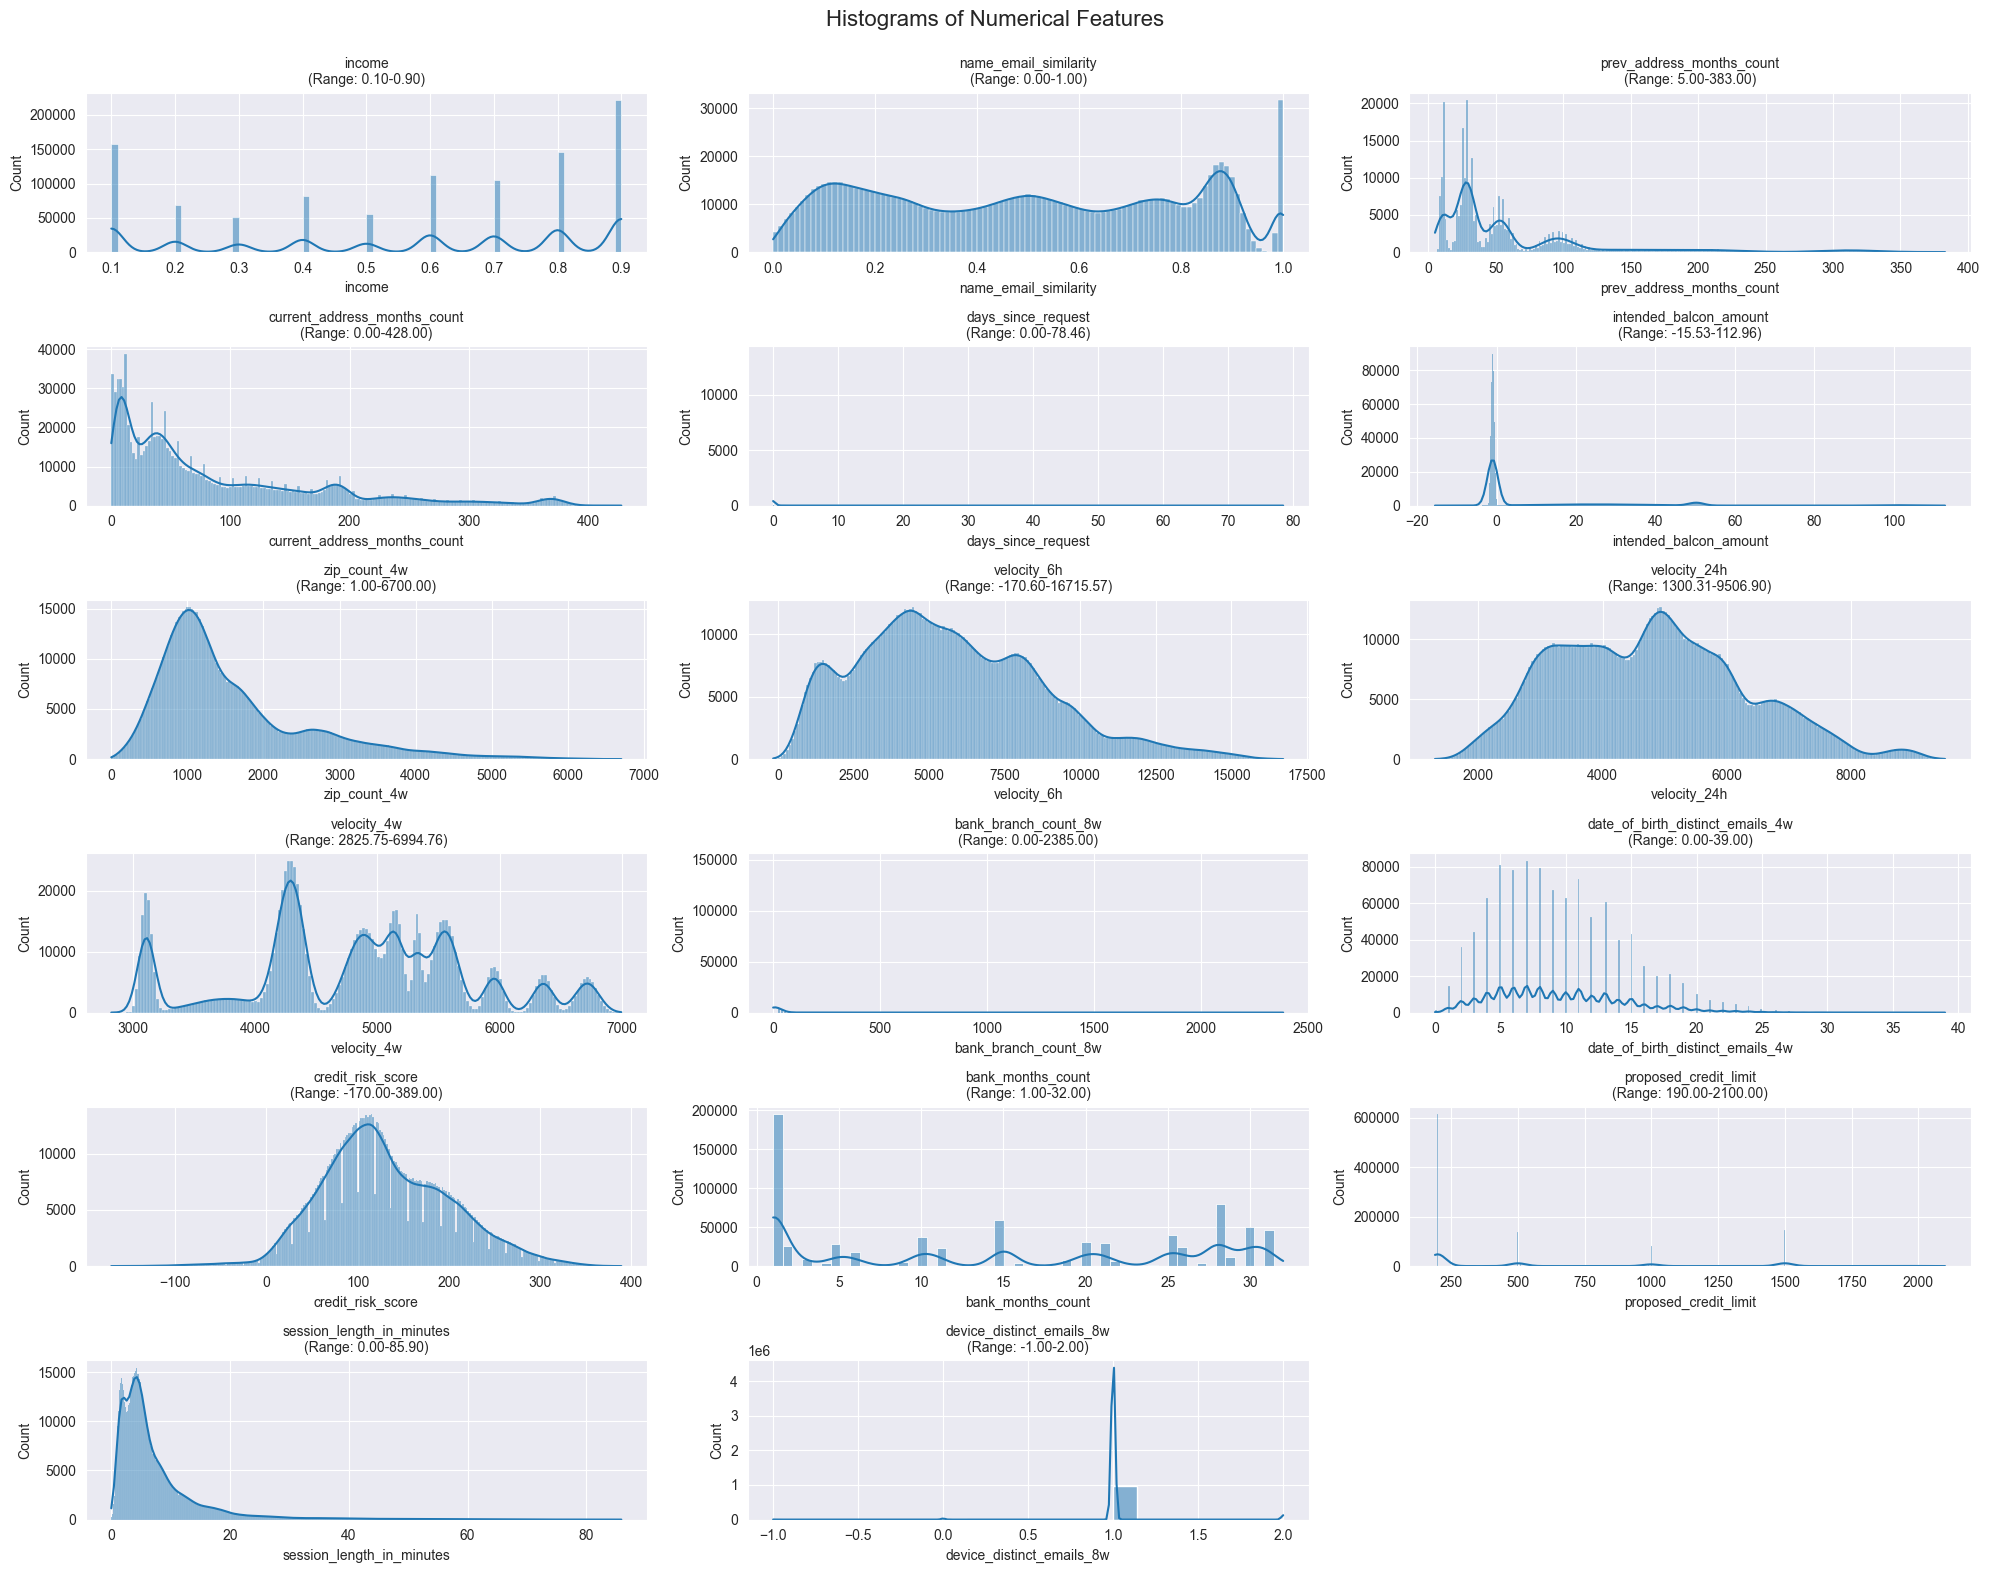

In [20]:
# --- 3. Univariate Analysis ---
print("\n--- Univariate Analysis ---")
# (Plotting functions remain the same, but their interpretation changes with full data)

# Histograms for numerical features
if numerical_features:
    plt.figure(figsize=(20, 16))
    num_cols_plot = 3 # Number of columns in subplot grid
    num_rows_plot = (len(numerical_features) - 1) // num_cols_plot + 1
    for i, col in enumerate(numerical_features):
        plt.subplot(num_rows_plot, num_cols_plot, i + 1)
        sns.histplot(df[col].dropna(), kde=True) # dropna for plotting robustness
        plt.title(f"{col}\n(Range: {df[col].min():.2f}-{df[col].max():.2f})", fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout
    plt.suptitle("Histograms of Numerical Features", y=0.98, fontsize=16)
    plt.show()
else:
    print("No numerical features identified for histograms.")

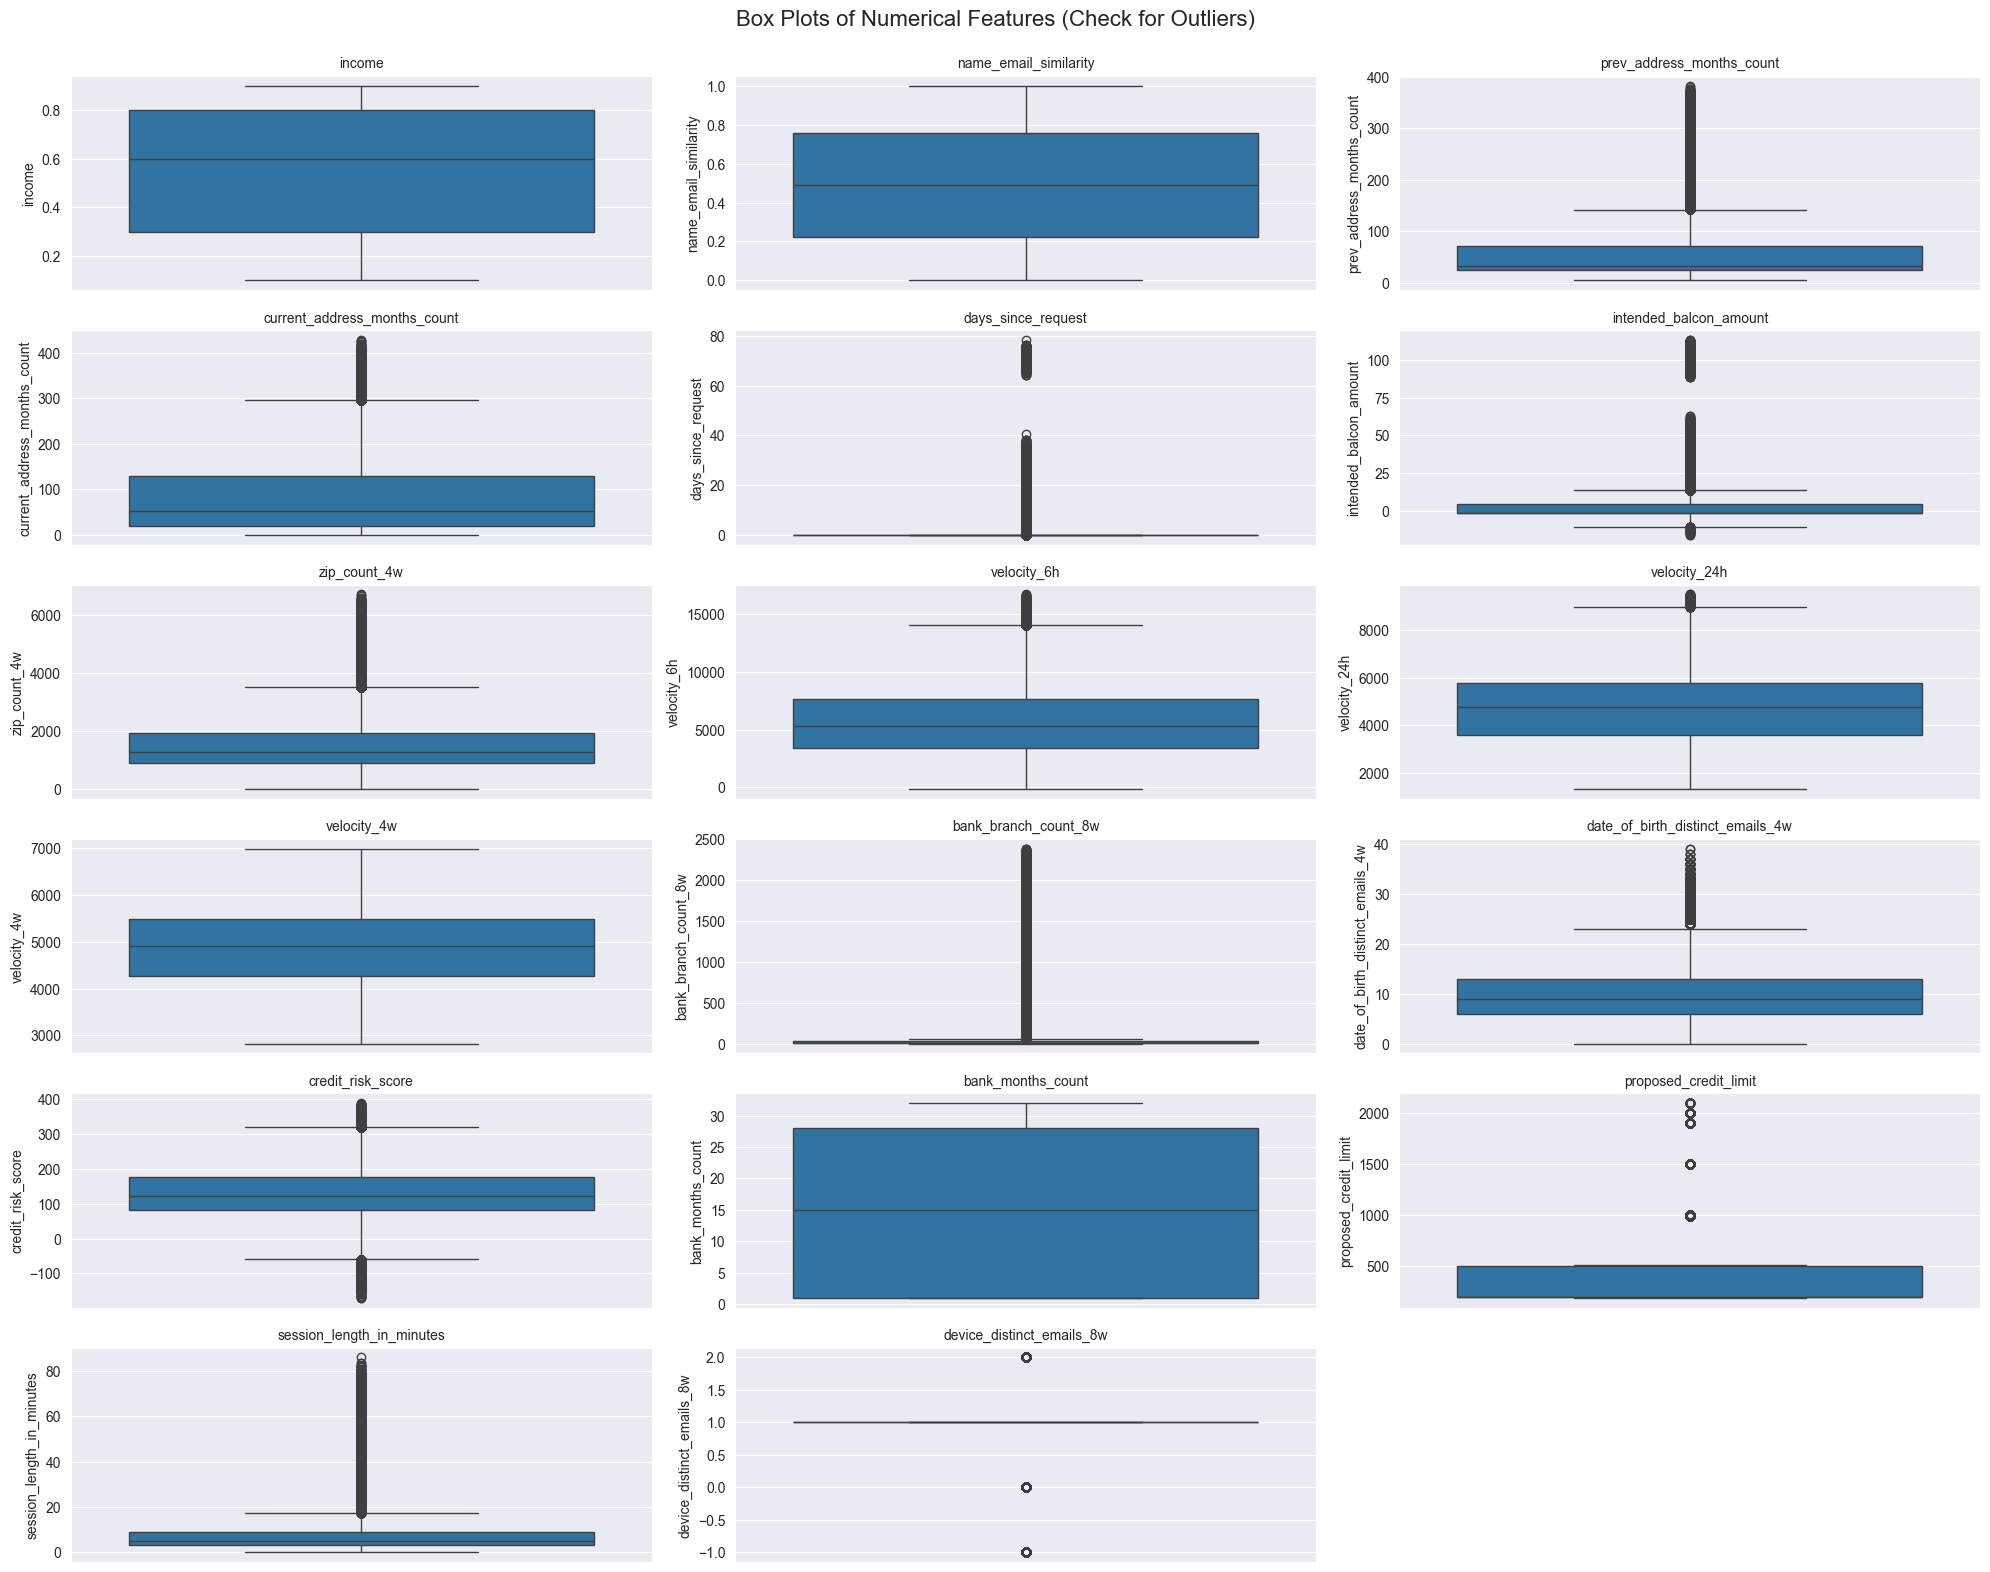

In [21]:
# Box plots for numerical features
if numerical_features:
    plt.figure(figsize=(20, 16))
    for i, col in enumerate(numerical_features):
        plt.subplot(num_rows_plot, num_cols_plot, i + 1) # Use same grid as histograms
        sns.boxplot(y=df[col].dropna())
        plt.title(col, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Box Plots of Numerical Features (Check for Outliers)", y=0.98, fontsize=16)
    plt.show()
else:
    print("No numerical features identified for box plots.")


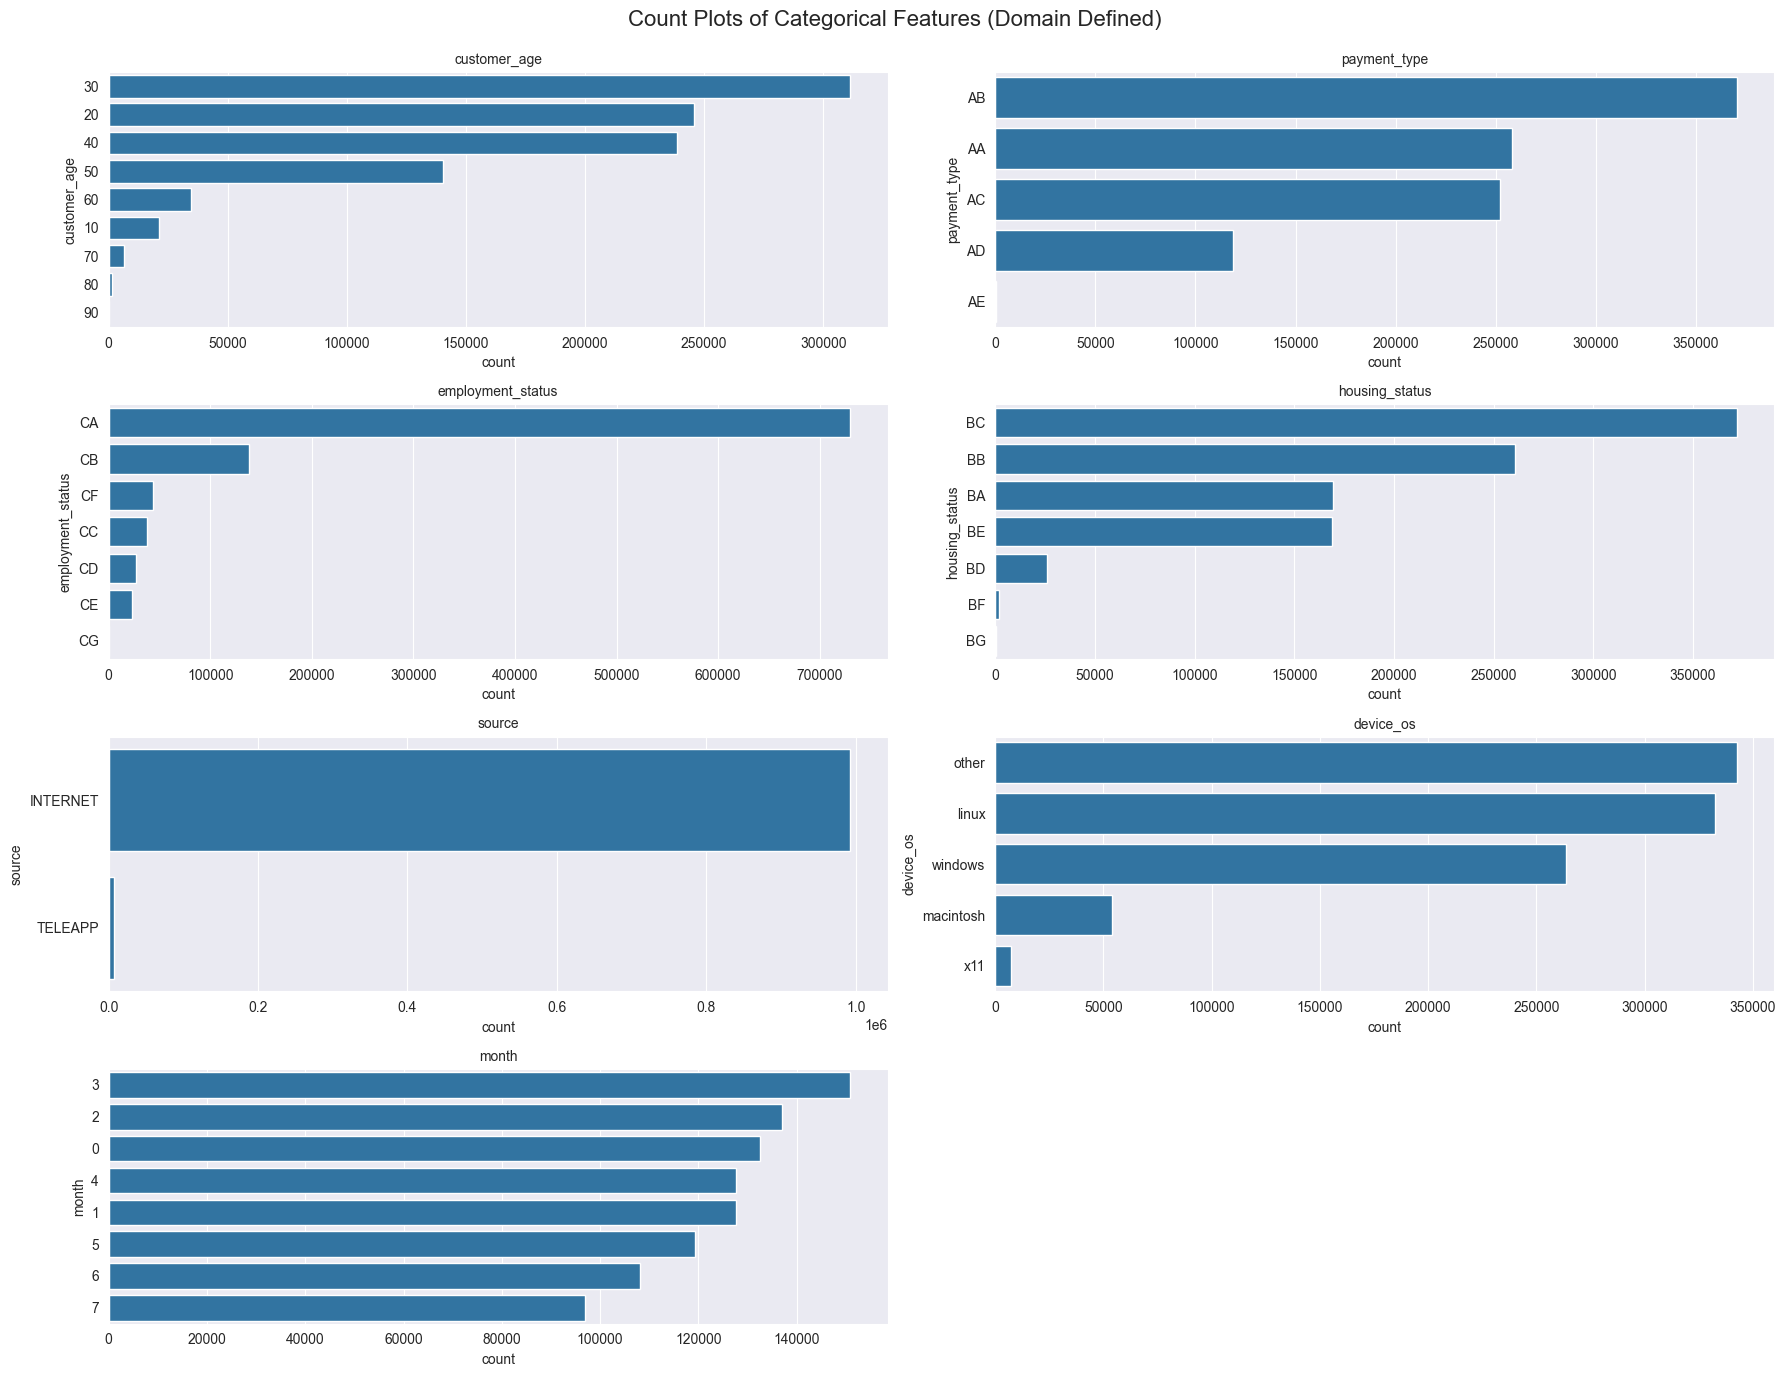

In [22]:
# Count plots for domain-defined categorical features
if categorical_features_domain:
    plt.figure(figsize=(18, max(12, len(categorical_features_domain) * 2))) # Dynamic height
    cat_cols_plot = 2 # Adjust if too cramped
    cat_rows_plot = (len(categorical_features_domain) - 1) // cat_cols_plot + 1
    for i, col in enumerate(categorical_features_domain):
        plt.subplot(cat_rows_plot, cat_cols_plot, i + 1)
        # Treat numerical representations of categories (like age bins, month) as strings for plotting
        if df[col].dtype in ['int64', 'float64'] and df[col].nunique() < 20: # Heuristic for discrete numbers
             sns.countplot(data=df, y=df[col].astype(str).fillna('NaN'), order = df[col].astype(str).fillna('NaN').value_counts().index)
        else:
             sns.countplot(data=df, y=df[col].fillna('NaN'), order = df[col].fillna('NaN').value_counts().index)
        plt.title(col, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Count Plots of Categorical Features (Domain Defined)", y=0.98, fontsize=16)
    plt.show()
else:
    print("No domain-defined categorical features identified for count plots.")


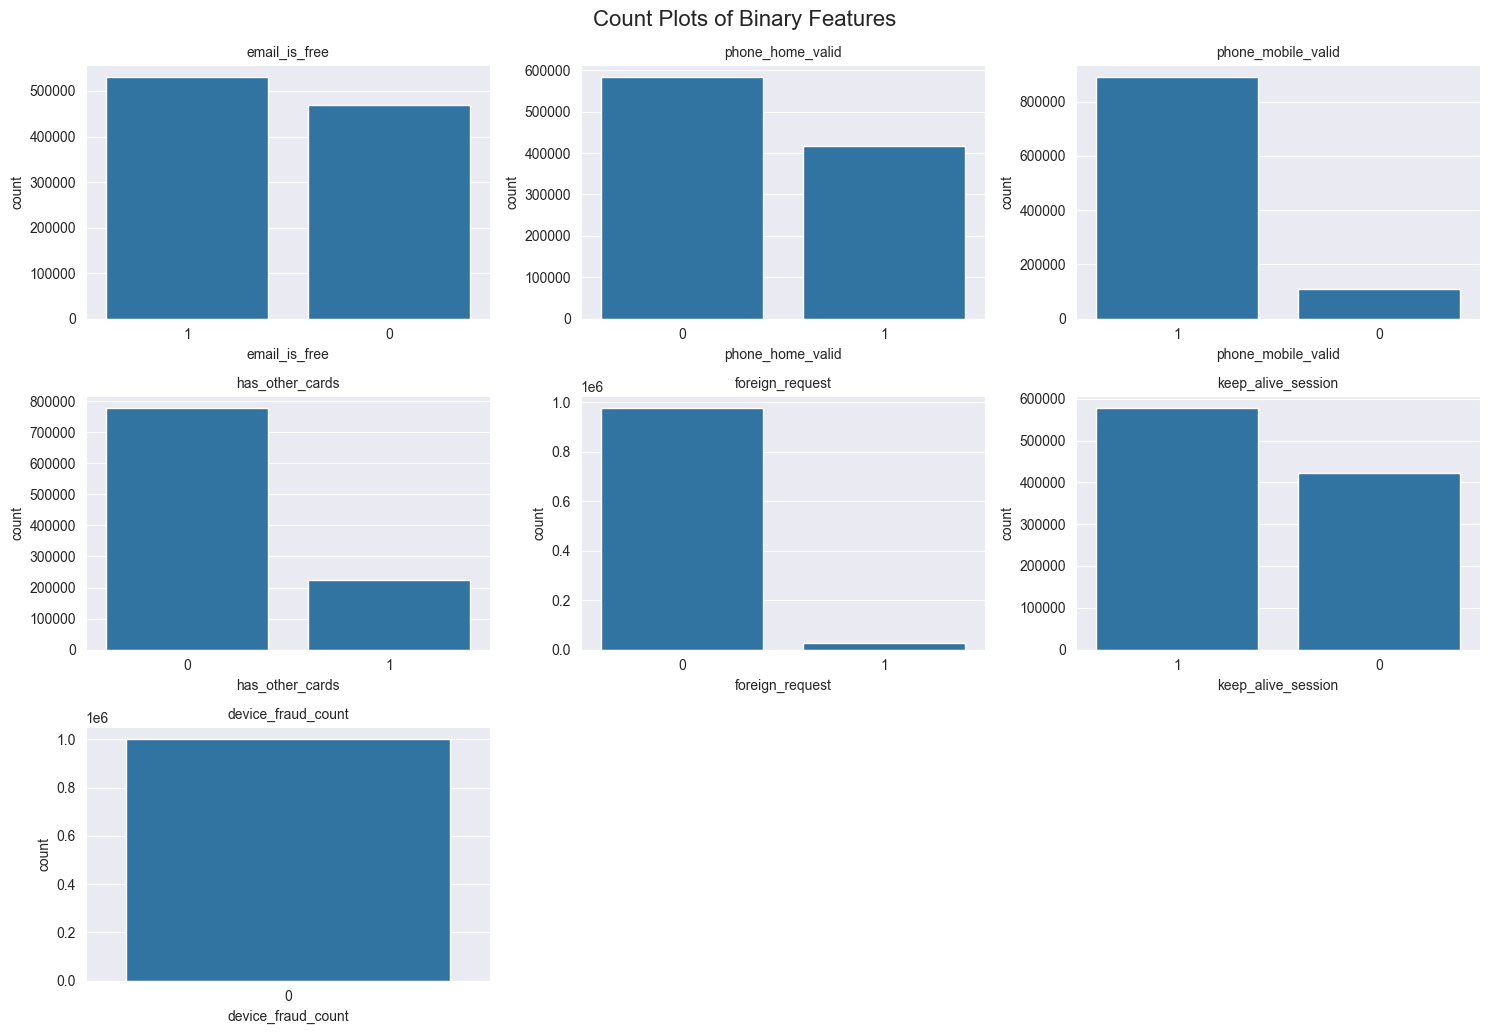

In [23]:
# Count plots for binary features
if binary_features:
    plt.figure(figsize=(15, max(10, len(binary_features) * 1.5))) # Dynamic height
    bin_cols_plot = 3
    bin_rows_plot = (len(binary_features) - 1) // bin_cols_plot + 1
    for i, col in enumerate(binary_features):
        plt.subplot(bin_rows_plot, bin_cols_plot, i + 1)
        sns.countplot(data=df, x=df[col].astype(str).fillna('NaN')) # astype(str) to handle potential float if NaNs were there
        plt.title(col, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle("Count Plots of Binary Features", y=0.98, fontsize=16)
    plt.show()
else:
    print("No binary features identified for count plots.")



--- Bivariate Analysis ---


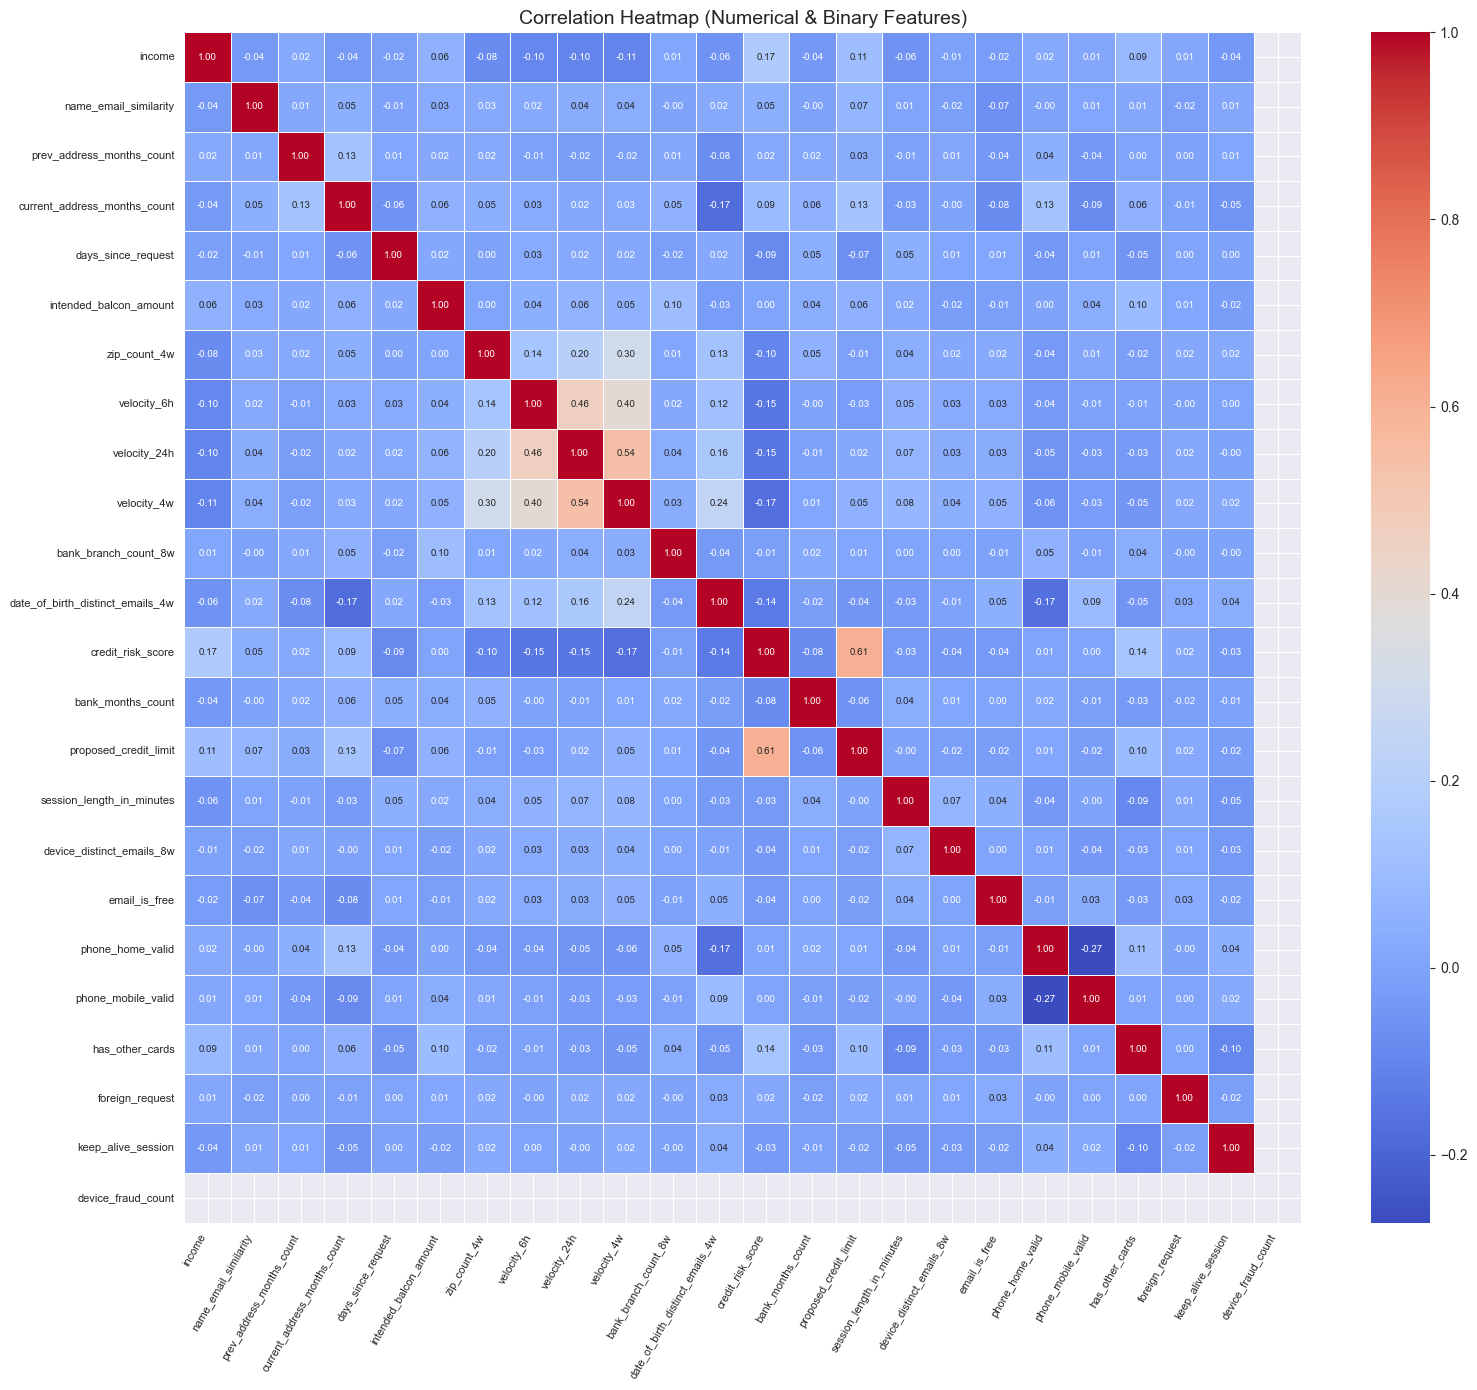

In [24]:
# --- 4. Bivariate Analysis ---
print("\n--- Bivariate Analysis ---")
# (Plotting functions remain, interpretation assumes full data for relationships)

# Correlation heatmap for numerical and binary features
if numerical_features or binary_features:
    plt.figure(figsize=(16, 14)) # Adjusted size for more features
    corr_df_features = [col for col in numerical_features + binary_features if col in df.columns]
    
    temp_df_for_corr = df[corr_df_features].copy()
    for col in binary_features: 
        if col in temp_df_for_corr.columns:
             temp_df_for_corr[col] = pd.to_numeric(temp_df_for_corr[col], errors='coerce')

    correlation_matrix = temp_df_for_corr.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 7}) # Smaller annotation font
    plt.title('Correlation Heatmap (Numerical & Binary Features)', fontsize=14)
    plt.xticks(rotation=60, ha="right", fontsize=8) # Adjusted rotation and font
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("No numerical or binary features for correlation heatmap.")

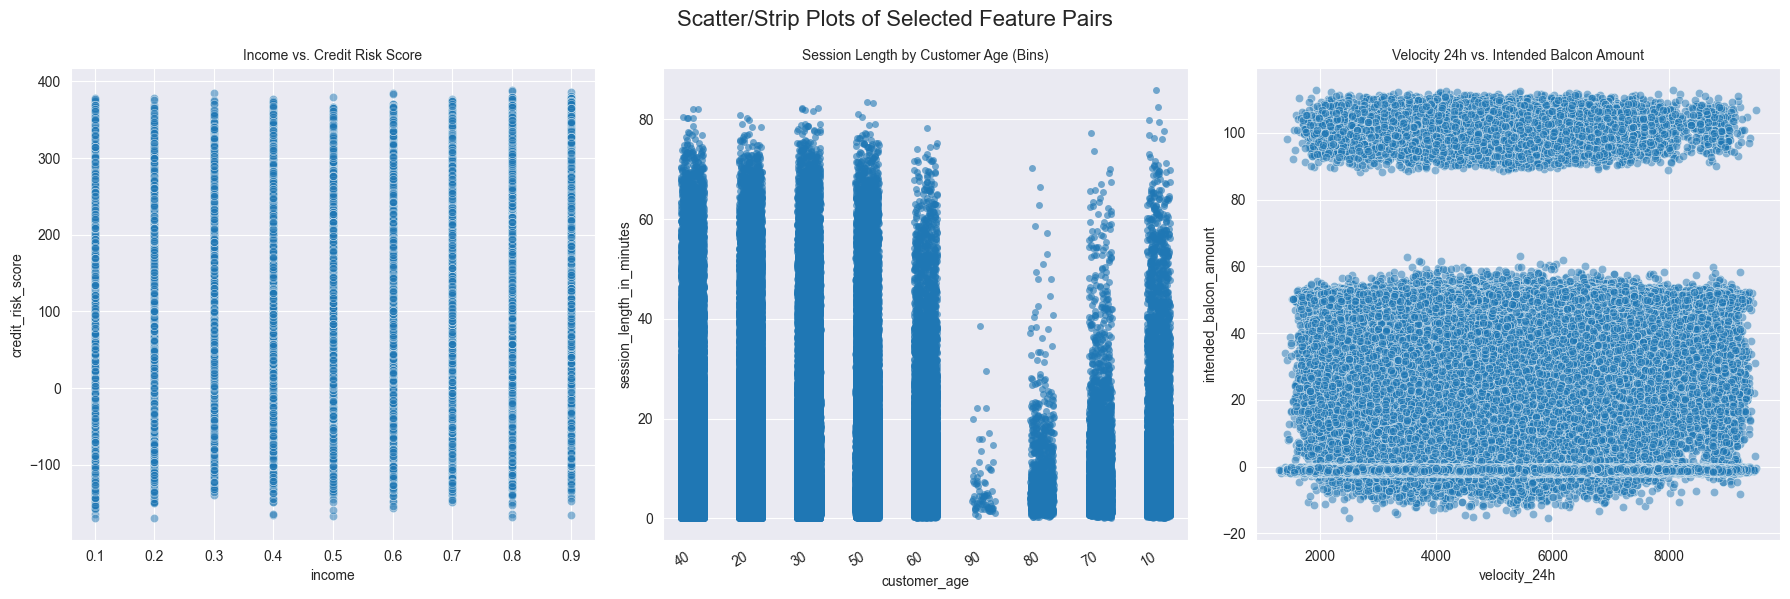

In [25]:
# Scatter plots for selected pairs of numerical features
if len(numerical_features) >= 2:
    plt.figure(figsize=(18, 6))
    # Pair 1
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df, x='income', y='credit_risk_score', alpha=0.5) # Added alpha for potentially dense plots
    plt.title('Income vs. Credit Risk Score', fontsize=10)
    # Pair 2: customer_age (categorical) vs. session_length_in_minutes (numerical)
    plt.subplot(1, 3, 2)
    sns.stripplot(data=df, x=df['customer_age'].astype(str).fillna('NaN'), y='session_length_in_minutes', jitter=0.2, alpha=0.6)
    plt.title('Session Length by Customer Age (Bins)', fontsize=10)
    plt.xticks(rotation=30, ha='right')
    # Pair 3
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=df, x='velocity_24h', y='intended_balcon_amount', alpha=0.5)
    plt.title('Velocity 24h vs. Intended Balcon Amount', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Scatter/Strip Plots of Selected Feature Pairs", y=0.99, fontsize=16)
    plt.show()
else:
    print("Not enough numerical features for scatter plots.")

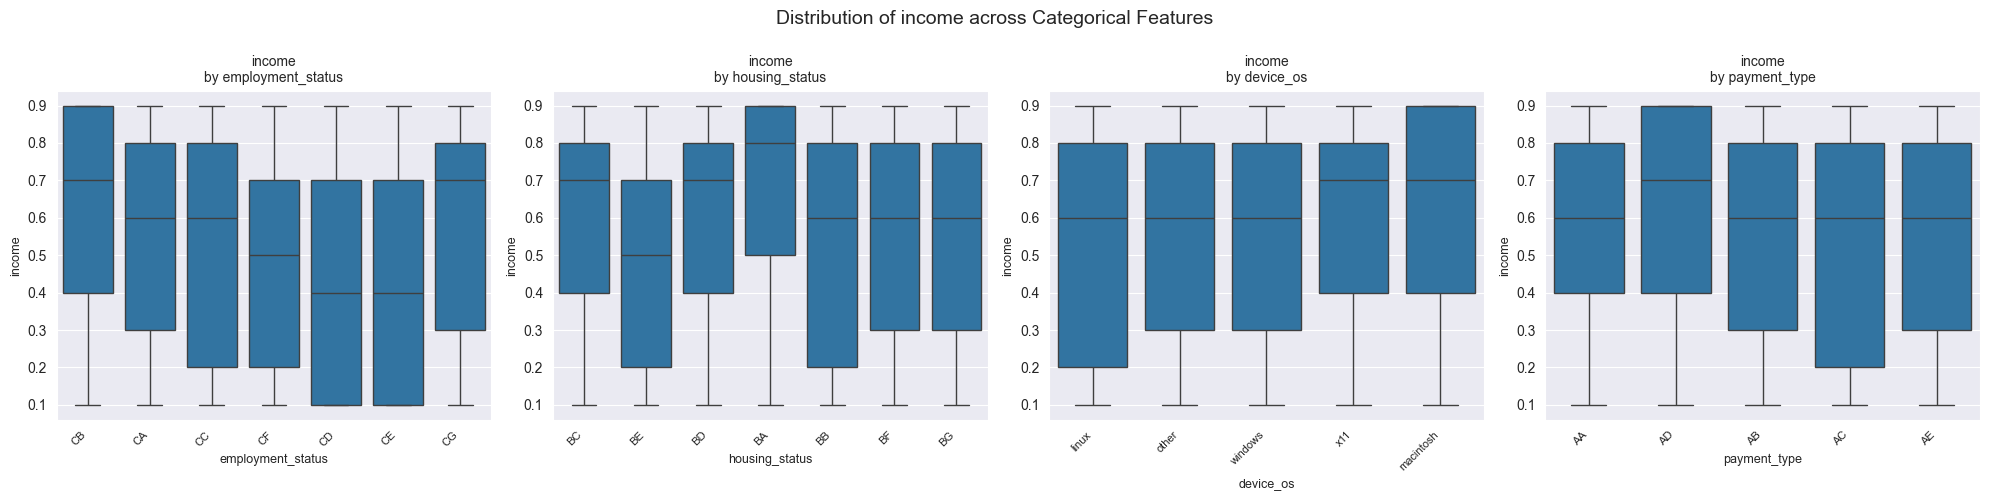

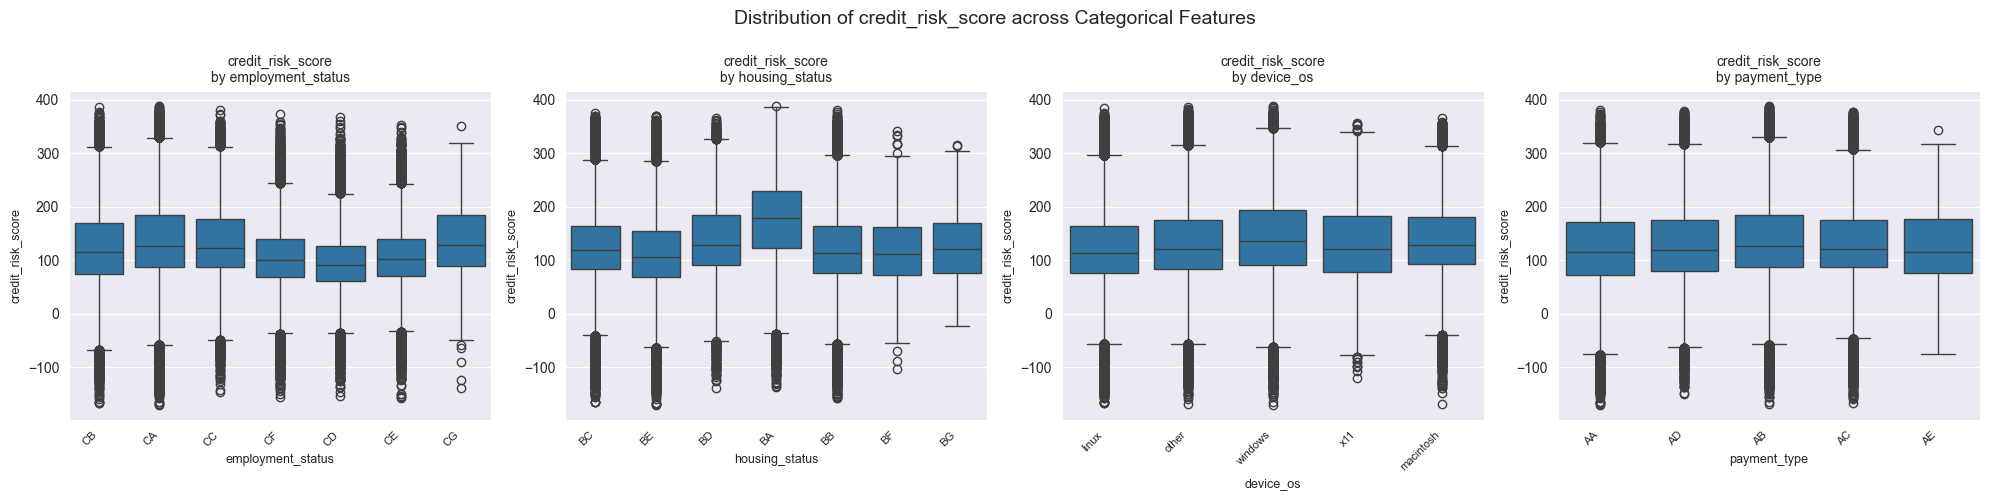

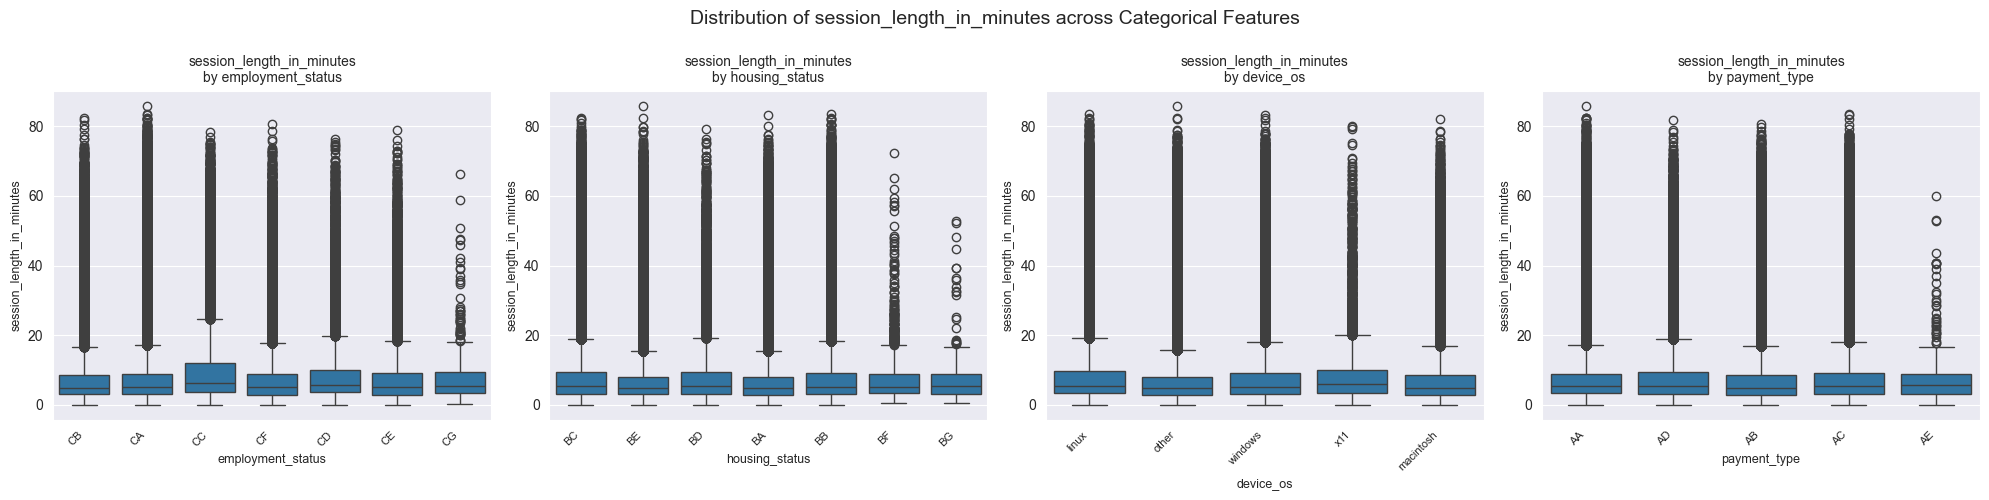

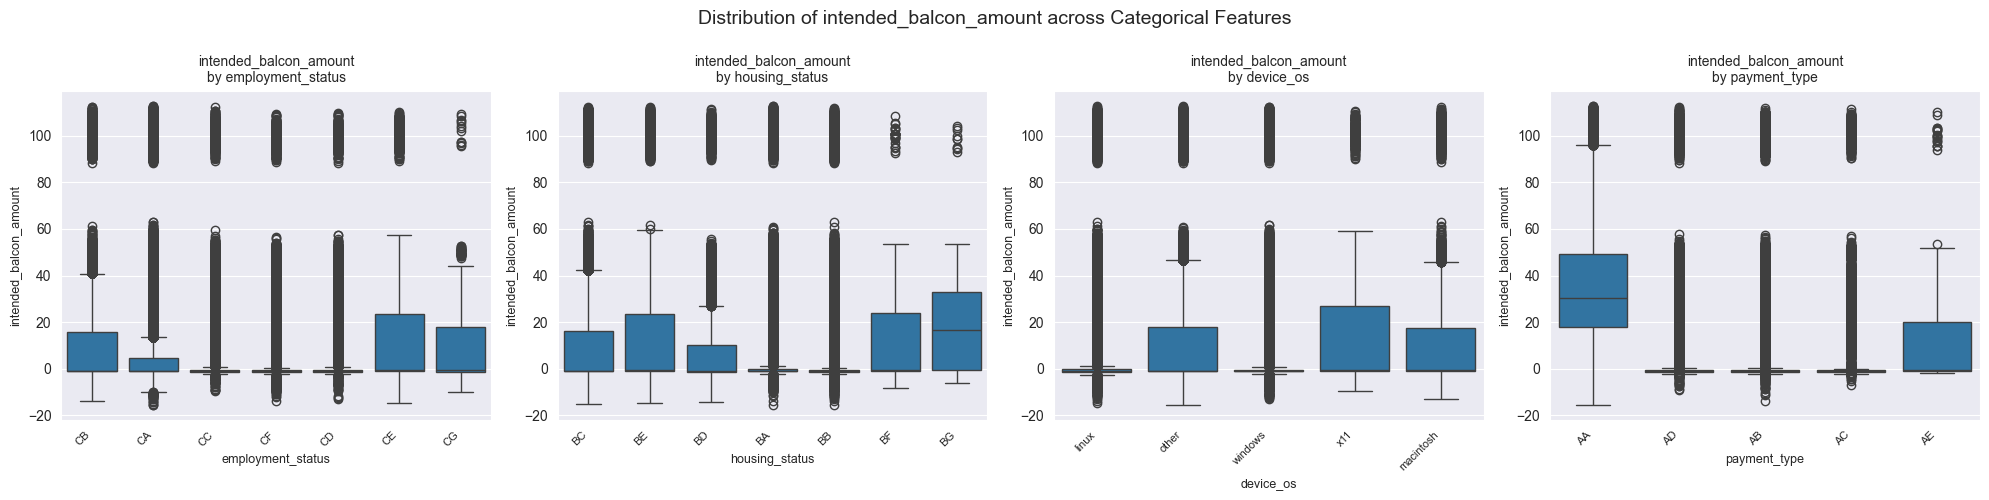

In [26]:
# Box plots of numerical features grouped by key categorical features
if numerical_features and categorical_features_domain:
    # Select a few key categorical features for grouping
    grouping_cats = [cat for cat in ['employment_status', 'housing_status', 'device_os', 'payment_type'] if cat in categorical_features_domain]
    # Select a few key numerical features to be grouped
    grouped_nums = [num for num in ['income', 'credit_risk_score', 'session_length_in_minutes', 'intended_balcon_amount'] if num in numerical_features]

    if grouping_cats and grouped_nums:
        for num_feat in grouped_nums:
            plt.figure(figsize=(min(20, 5 * len(grouping_cats)), 5)) # Dynamic width
            for i, cat_feat in enumerate(grouping_cats):
                plt.subplot(1, len(grouping_cats), i + 1)
                sns.boxplot(data=df, x=cat_feat, y=num_feat)
                plt.title(f'{num_feat}\nby {cat_feat}', fontsize=10)
                plt.xticks(rotation=45, ha='right', fontsize=8)
                plt.xlabel(cat_feat, fontsize=9)
                plt.ylabel(num_feat, fontsize=9)
            plt.tight_layout(rect=[0, 0, 1, 0.93])
            plt.suptitle(f"Distribution of {num_feat} across Categorical Features", y=0.99, fontsize=14)
            plt.show()
    else:
        print("Not enough suitable numerical or categorical features for grouped box plots.")
else:
    print("Not enough numerical or categorical features for grouped box plots.")

In [ ]:
# --- 5. EDA Summary & Observations (Assuming full dataset for interpretation) ---
print("\n--- EDA Summary & Observations (Interpreting for Full 'Base.csv') ---")
print(f"1. Data Size: The full dataset is expected to have ~1 million rows and {df.shape[1]} columns.")
print(f"2. Target Variable ('fraud_bool'): Analysis of the 'fraud_bool' distribution on the full dataset is CRITICAL. Understanding the class imbalance (percentage of fraud vs. legit) is key for modeling.")
print("3. Data Cleaning & Special Values (based on domain knowledge):")
print(f"   - Columns like 'prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes' had -1 values (missing/error per domain) converted to NaN. The extent of missingness in the full dataset should be checked.")
print(f"   - 'intended_balcon_amount': Negative values (near -1) might be placeholders or minor fees. Their frequency and correlation with fraud in the full dataset would be insightful.")
print(f"   - 'velocity_6h': Negative values are unusual for an 'average applications per hour' metric. Their prevalence and nature in the full dataset need investigation (data error, specific system behavior, or complex definition).")
print(f"   - 'credit_risk_score': Negative values are part of its valid domain.")
print("4. Missing Values: The percentage of missing values for each column in the full dataset should be carefully analyzed to decide on imputation strategies if needed.")
print("5. Feature Distributions (to be observed on full data):")
print("   - Numerical Features: Histograms and box plots on the full dataset will reveal true distributions, identify outliers (e.g., the high 'bank_branch_count_8w' value seen in the sample), and show skewness. This informs transformation needs (e.g., log transform for skewed data).")
print("   - Categorical Features: Count plots on the full dataset will show the actual frequencies of different categories (e.g., 'customer_age' bins, 'payment_type', 'employment_status', 'device_os'). Rare categories might need grouping.")
print("   - Binary Features: Proportions of 0s and 1s for flags like 'email_is_free', 'foreign_request' will be clear.")
print("6. Correlations: The heatmap on the full dataset will provide more reliable insights into linear relationships between features. Strong correlations might suggest multicollinearity.")
print("7. Bivariate Analysis with Target ('fraud_bool'): THIS IS KEY and was not possible with the sample.")
print("   - For numerical features: Compare distributions (e.g., using overlaid histograms or box plots) for fraudulent vs. non-fraudulent transactions (e.g., 'is income different for fraud?', 'is credit_risk_score different for fraud?').")
print("   - For categorical features: Compare proportions (e.g., using grouped bar charts) for fraudulent vs. non-fraudulent transactions (e.g., 'is a particular payment_type more prone to fraud?').")
print("8. Constant or Near-Constant Columns: Identify any columns with very low variance in the full dataset as they might not be useful for modeling.")
print("\nKey Next Steps for EDA on Full 'Base.csv':")
print("- **Analyze 'fraud_bool'**: Determine class imbalance. This will heavily influence model selection and evaluation metrics.")
print("- **Detailed Missing Value Analysis**: Quantify missingness and plan imputation or handling strategies.")
print("- **Outlier Detection and Treatment**: Investigate outliers in numerical features and decide on handling (capping, removing, transforming).")
print("- **Target-Correlated Bivariate Analysis**: Systematically explore relationships of each feature with 'fraud_bool'.")
print("- **Feature Engineering**: Based on insights, consider creating new features (e.g., ratios, interactions, aggregations over time if applicable).")
print("- **Consult Domain Experts**: For any ambiguous data points or patterns (like negative velocities), expert input is invaluable.")

